In [61]:
#reference 
'''
https://github.com/AntixK/PyTorch-VAE
Dataset - https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

'''

'\nhttps://github.com/AntixK/PyTorch-VAE\nDataset - https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html\n\n'

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim 

In [ ]:
from pathlib import Path
from typing import List, Optional, Sequence, Union, Any, Callable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Subset

from torchvision.datasets import CelebA

class MyCelebA(CelebA):    
    def _check_integrity(self) -> bool:
        return True

class VAEDataset(Dataset):
    def __init__(
        self,
        data_path: str = 'celeba',
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        patch_size: Union[int, Sequence[int]] = (256, 256), # the size of the crop to take from the original images.
        num_workers: int = 0,
        pin_memory: bool = False, # whether prepared items should be loaded into pinned memory or not. This can improve performance on GPUs.
        **kwargs,):
        
        super().__init__()

        self.data_dir = data_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        
    def setup(self, stage: Optional[str] = None) -> None:
        train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.CenterCrop(148),
                                              transforms.Resize(self.patch_size),
                                              transforms.ToTensor(),])
        
        val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(148),
                                            transforms.Resize(self.patch_size),
                                            transforms.ToTensor(),])
        
        self.train_dataset = MyCelebA(
            self.data_dir,
            split='train',
            transform=train_transforms,
            download=False,
        )
        
        self.train_dataset = Subset(self.train_dataset, range(1000))
        
        # Replace CelebA with your dataset
        self.val_dataset = MyCelebA(
            self.data_dir,
            split='test',
            transform=val_transforms,
            download=False,
        )
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

In [ ]:
vae_data = VAEDataset()
vae_data.setup()
train_data = vae_data.train_dataloader()

In [ ]:
dataiter = iter(train_data)
image, label = next(dataiter)

In [ ]:
image.shape #batch, channels(RGB), dim, dim

In [71]:
#residual block - pass input directly without any processing
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False))
        
    def forward(self, x):
        
        return x + self.resblock(x)

In [88]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        modules = []
        modules.append(nn.Sequential(nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(ResidualBlock(128, 128))
        modules.append(ResidualBlock(128, 128))
        modules.append(ResidualBlock(128, 128))
        modules.append(ResidualBlock(128, 128))
        modules.append(nn.LeakyReLU())
        modules.append(nn.Sequential(nn.Conv2d(128, latent_dim, kernel_size=1, stride=1),
                      nn.LeakyReLU()))
        self.encoder = nn.Sequential(*modules)
        
    def forward(self, x):
        result = self.encoder(x)
        return result

In [89]:
latent_dim = 128 
encoder = Encoder(latent_dim)

result = encoder(image)
print(result.shape)

torch.Size([8, 128, 32, 32])


## Decoder

In [92]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        modules = []
        modules.append(nn.Sequential(nn.Conv2d(latent_dim, 128, kernel_size=1, stride=1),
                      nn.LeakyReLU()))
        modules.append(ResidualBlock(128, 128))
        modules.append(ResidualBlock(128, 128))
        modules.append(ResidualBlock(128, 128))
        modules.append(ResidualBlock(128, 128))
        modules.append(nn.LeakyReLU())
        modules.append(nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU()))
        modules.append(nn.Sequential(nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
                      nn.Tanh()))
        
        self.decoder = nn.Sequential(*modules)
        

    def forward(self, z):
        result = self.decoder(z)
        return result


In [93]:
latent_dim = 128 
decoder = Decoder(latent_dim)

result = decoder(result)
print(result.shape)

torch.Size([8, 3, 256, 256])


In [94]:
import torch.nn.functional as F

class VQ(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super(VQ, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta
        
        #initilaize codebook
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        
    def forward(self, z):
        #flatten
        z_flattened = z.view(-1, self.embedding_dim)
        
        #l2 norm distance (a-b)**2
        distances = (
            torch.sum(z_flattened ** 2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight ** 2, dim=1)
            - 2 * torch.matmul(z_flattened, self.embeddings.weight.t())
        )
        
        #closest embedding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings)
        #one hot encoding 
        encodings.scatter_(1, encoding_indices, 1)
        
        #quantize
        quantized = torch.matmul(encodings, self.embeddings.weight).view(z.shape)
        
        commitment_loss = F.mse_loss(quantized.detach(), z)
        embedding_loss = F.mse_loss(quantized, z.detach())
        
        vq_loss = commitment_loss * self.beta + embedding_loss
        
        quantized = z + (quantized - z).detach()
        return quantized, vq_loss

In [95]:
class VQVAE(nn.Module):
    def __init__(self, latent_dim, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.quantizer = VQ(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss = self.quantizer(z)
        recon_x = self.decoder(quantized)
        return recon_x, vq_loss

In [96]:
def loss_function(recon_x, x, loss):
    recon_loss = F.mse_loss(recon_x, x)
    return recon_loss + loss, recon_loss, loss

In [97]:
latent_dim = 64
num_embeddings = 512
embedding_dim = 64
commitment_cost = 0.25
epochs = 12
learning_rate = 1e-3

vqvae = VQVAE(latent_dim, num_embeddings, embedding_dim, commitment_cost)
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)

In [98]:
len(train_data)

125

In [99]:
from tqdm import tqdm

for epoch in range(epochs):
    vqvae.train()
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_data)):
        data = data
        optimizer.zero_grad()
        recon_batch, loss_batch = vqvae(data)
        loss, recon_loss, vqvae_loss = loss_function(recon_batch, data, loss_batch)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss}, Recon Loss : {recon_loss}, VQVAE_loss : {vqvae_loss}')

125it [00:59,  2.09it/s]


Epoch 1, Loss: 14.705845832824707, Recon Loss : 0.05371686443686485, VQVAE_loss : 14.652129173278809


125it [00:58,  2.13it/s]


Epoch 2, Loss: 0.6650784611701965, Recon Loss : 0.03792944923043251, VQVAE_loss : 0.6271489858627319


125it [00:59,  2.11it/s]


Epoch 3, Loss: 0.3095376491546631, Recon Loss : 0.026622913777828217, VQVAE_loss : 0.2829147279262543


125it [01:00,  2.08it/s]


Epoch 4, Loss: 0.16680386662483215, Recon Loss : 0.019127432256937027, VQVAE_loss : 0.14767643809318542


125it [00:59,  2.10it/s]


Epoch 5, Loss: 0.07570574432611465, Recon Loss : 0.012847818434238434, VQVAE_loss : 0.06285792589187622


125it [00:59,  2.10it/s]


Epoch 6, Loss: 0.06245099753141403, Recon Loss : 0.008884022943675518, VQVAE_loss : 0.05356697365641594


125it [00:59,  2.10it/s]


Epoch 7, Loss: 0.06858804821968079, Recon Loss : 0.008630603551864624, VQVAE_loss : 0.05995744466781616


125it [01:00,  2.08it/s]


Epoch 8, Loss: 0.042178183794021606, Recon Loss : 0.004897344391793013, VQVAE_loss : 0.037280838936567307


125it [01:00,  2.06it/s]


Epoch 9, Loss: 0.045314498245716095, Recon Loss : 0.005556283984333277, VQVAE_loss : 0.039758212864398956


125it [01:00,  2.08it/s]


Epoch 10, Loss: 0.042039141058921814, Recon Loss : 0.00418290589004755, VQVAE_loss : 0.03785623610019684


125it [01:00,  2.05it/s]


Epoch 11, Loss: 0.03875643014907837, Recon Loss : 0.004353595897555351, VQVAE_loss : 0.03440283611416817


125it [01:00,  2.08it/s]

Epoch 12, Loss: 0.041522316634655, Recon Loss : 0.004388689529150724, VQVAE_loss : 0.03713362663984299


In [100]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, n=8):
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[1, i].axis('off')
    plt.show()
    
    

vqvae.eval()
dataiter = iter(train_data)
image, label = next(dataiter)

reconstructed, loss = vqvae(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


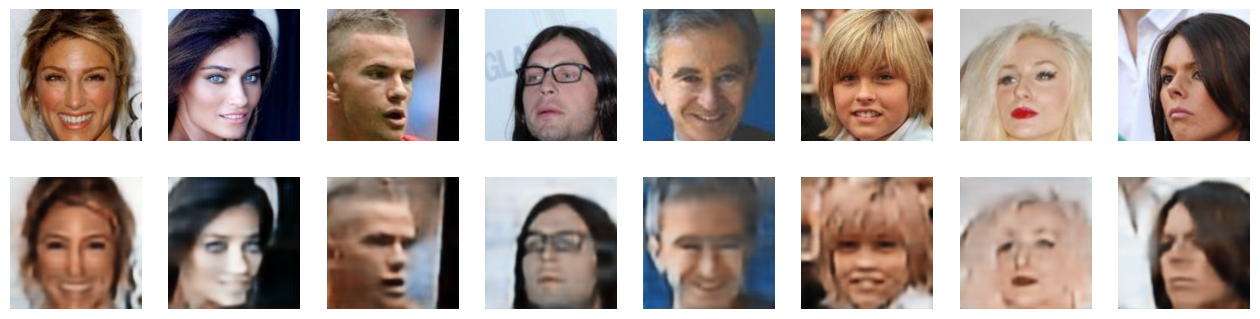

In [101]:
show_images(image, reconstructed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


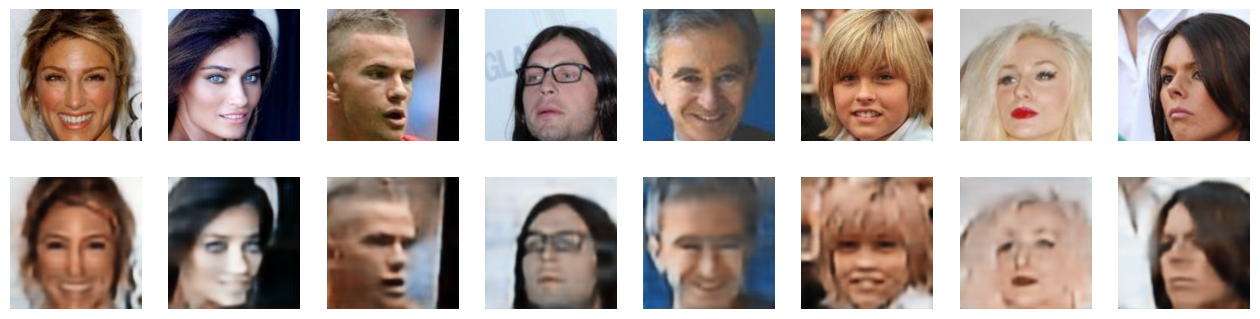

In [102]:
show_images(image, reconstructed)